In [1]:
# %pip install calmap

# Search observations example

In this example we get the full list of observations and figure out which field (according to `field_name`) has the most images.

We then take the coordinates for that field and find all observations (regardless of `field_name`) and make some plots to show the coverage.

Finally, an example showing how to loop over the results and write out a text file that can be used with `wget` for downloading. Note that you could also download directly here.

If you have a lot of downloads to do we recommend using [`gsutil`](https://cloud.google.com/storage/docs/gsutil)

In [2]:
import pandas as pd
import calmap

from panoptes.data.search import search_observations
from panoptes.data.observations import ObservationInfo

## Get observations data

In [3]:
# This is updated daily.
fn = 'https://storage.googleapis.com/panoptes-assets/observations.csv'

In [4]:
# Read the remote file.
observations = pd.read_csv(fn)

In [5]:
# Show size and fields.
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7765 entries, 0 to 7764
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       7765 non-null   object 
 1   num_images                 7765 non-null   int64  
 2   software_version           7765 non-null   object 
 3   sequence_id                7765 non-null   object 
 4   image_type                 6691 non-null   object 
 5   unit_id                    7765 non-null   object 
 6   imagew                     7765 non-null   int64  
 7   total_exptime              7765 non-null   float64
 8   field_name                 7765 non-null   object 
 9   imageh                     7765 non-null   int64  
 10  camera_camera_id           7765 non-null   object 
 11  camera_lens_serial_number  7765 non-null   object 
 12  camera_serial_number       7765 non-null   int64  
 13  coordinates_mount_ha       7765 non-null   float

In [6]:
# Show a random sample of rows, transposed for easy viewing of all fields.
observations.sample(3).T

,4619,3069,2146
time,2019-05-24 08:04:44+00:00,2020-01-05 05:28:54+00:00,2020-10-29 11:58:48+00:00
num_images,30,27,15
software_version,POCSv0.6.2,POCSv0.6.2,POCSv0.6.2
sequence_id,PAN001_ee04d1_20190524T080444,PAN001_ee04d1_20200105T052854,PAN012_358d0f_20201029T115848
image_type,SCIENCE,SCIENCE,SCIENCE
unit_id,PAN001,PAN001,PAN012
imagew,5208,5208,5208
total_exptime,4509.0,1622.7,1800.0
field_name,TESS_SEC10_CAM01,TESS_SEC17_CAM02,TESS_SEC21_CAM01
imageh,3476,3476,3476


In [7]:
observations['date_time'] = pd.to_datetime(observations.time).dt.tz_localize(None)

In [8]:
obs_by_day = observations.set_index('date_time').resample('D').num_images.sum()

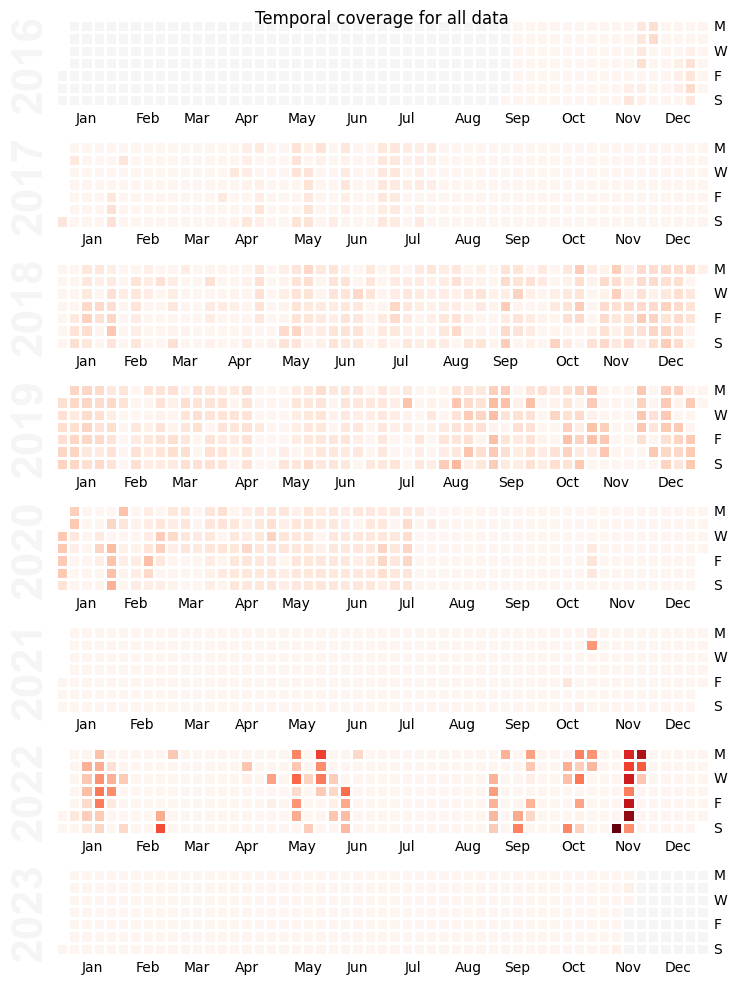

In [9]:
# Show temporal coverage of field.
fig, axes = calmap.calendarplot(
    obs_by_day, 
    daylabels='MTWTFSS',
    dayticks=[0, 2, 4, 6],
    linewidth=2,
    fig_kws=dict(figsize=(10, 10))
)
fig.suptitle(f'Temporal coverage for all data');

## Find field with the most images

In [10]:
# Group the observations by field name, then sum the total number of images and exptime. Get the "average" coordinates.
obs_totals = observations.groupby(['field_name']).agg({
    'num_images': 'sum',
    'total_exptime': 'sum',
    'coordinates_mount_ra': 'median',
    'coordinates_mount_dec': 'median',
}).reset_index()

# Sort the top fields by number of images (note total_exptime differences).
obs_totals = obs_totals.sort_values(by='num_images', ascending=False)

# Show the top ten.
obs_totals.head(10)

,field_name,num_images,total_exptime,coordinates_mount_ra,coordinates_mount_dec
139,TESS_SEC17_CAM02,20393,1914510.2,3.285700,48.231800
20,FU Orionis,17864,2133208.0,86.343175,9.070086
160,TESS_SEC23_CAM03,12031,1489065.0,228.127600,53.470400
113,TESS_SEC06_CAM01,10855,1304163.9,92.814500,5.407900
175,Tres 3,9962,1249106.6,268.029250,37.546167
50,KIC 8462852,9451,1137469.8,301.564390,44.456875
5,Andromeda,8109,967867.0,10.684710,41.268700
41,HD 189733,7414,664449.8,300.182138,22.710853
122,TESS_SEC10_CAM01,6745,860586.7,189.900200,-23.887800
167,Tau 02,6688,798784.0,69.000000,26.000000


In [11]:
# Get coordinates for top field.
top_field = obs_totals.iloc[0].field_name
top_ra = obs_totals.iloc[0].coordinates_mount_ra
top_dec = obs_totals.iloc[0].coordinates_mount_dec

## Get observations in the field

In [12]:
# Get all the observations from around the top field coordinates, regardless of field name, that have at least 10 images per observation.
top_observations = search_observations(
    ra=top_ra,
    dec=top_dec,
    min_num_images=10,
)

In [13]:
# Show a sample metadata record.
top_observations.sample(1).T

,3374
camera_id,14d3bd
camera_lens_serial_number,HA0028608
camera_serial_number,12070048413
coordinates_airmass,1.318283
coordinates_mount_dec,48.2318
coordinates_mount_ha,21.637526
coordinates_mount_ra,3.2857
field_name,TESS_SEC17_CAM02
image_type,SCIENCE
imageh,3476


### Coverage by unit

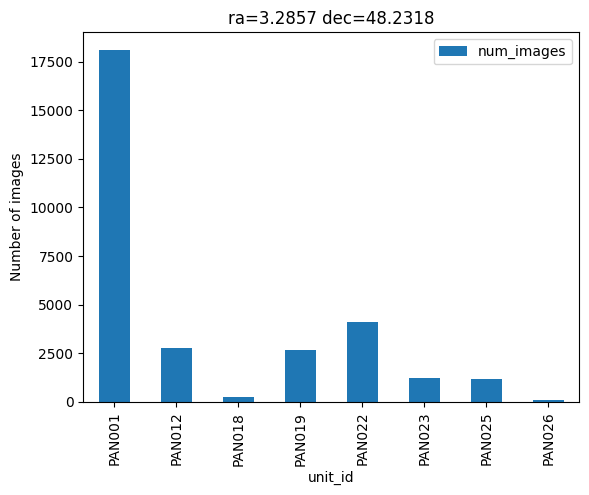

In [14]:
# Show the number of images by unit id.
top_units = top_observations.groupby(['unit_id']).agg({
    'num_images': 'sum',
}).reset_index()

top_units.plot(
    kind='bar',
    x='unit_id', y='num_images', 
    title=f'ra={top_ra} dec={top_dec}',
    ylabel='Number of images'
);

### Coverage by time

In [15]:
# Get the image count by (non-utc) day.
top_observations['date_time'] = top_observations.time.dt.tz_localize(None)
top_obs_day = top_observations.set_index('date_time').resample('D').num_images.sum()

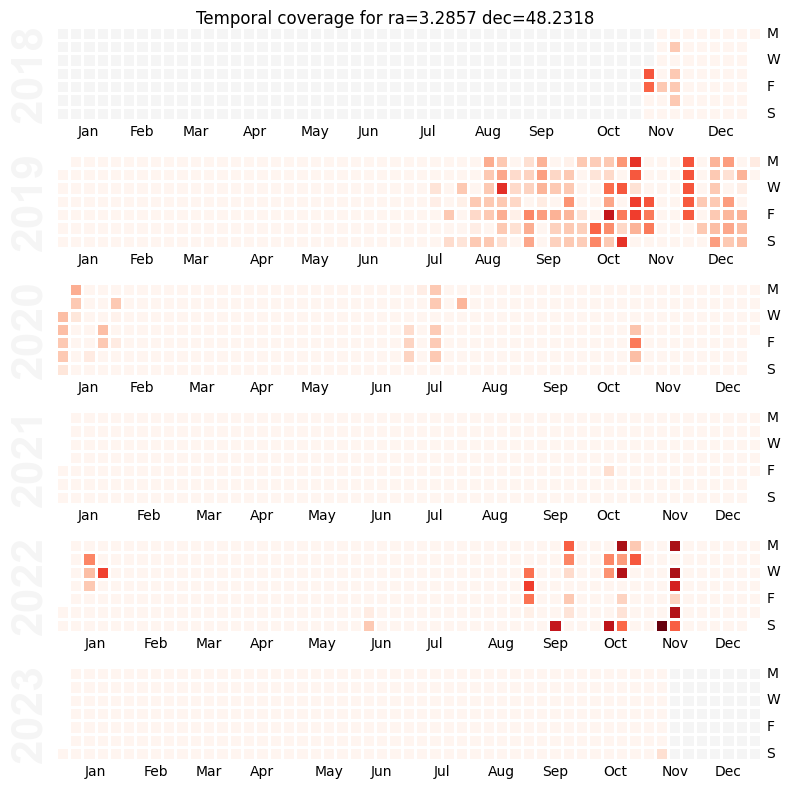

In [16]:
# Show temporal coverage of field.
fig, axes = calmap.calendarplot(
    top_obs_day, 
    daylabels='MTWTFSS',
    dayticks=[0, 2, 4, 6],
    fig_kws=dict(figsize=(8, 8)),
)
fig.suptitle(f'Temporal coverage for ra={top_ra} dec={top_dec}');

## Get image list for downloading

In [17]:
# Loop over top obs and create an ObservationInfo object to download the image list.
num_obs = 5

files = list()

for idx, row in top_observations.iloc[:num_obs].iterrows():
    # Get object.
    obs_info = ObservationInfo(meta=row)

    # Make filename.
    fn = f'{obs_info.sequence_id}-raw.txt'
    files.append(fn)

    # Put image list in dataframe and then write to csv.
    pd.DataFrame(obs_info.get_image_list()).to_csv(fn, index=False, header=False)

In [18]:
files

['PAN001_ee04d1_20181108T050226-raw.txt',
 'PAN001_14d3bd_20181108T050226-raw.txt',
 'PAN001_14d3bd_20181108T095440-raw.txt',
 'PAN001_ee04d1_20181108T095440-raw.txt',
 'PAN001_14d3bd_20181109T052947-raw.txt']

In [19]:
# Show the top of the file via the command line
!head {files[0]}

https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T050513.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T050807.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T051101.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T051353.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T051640.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T051924.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T052208.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T052455.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T052739.fits.fz
https://storage.googleapis.com/panoptes-images/PAN001/ee04d1/20181108T050226/20181108T05302

In [20]:
# Download the file via wget command line.
# !wget -i {files[0]}-raw.txt